In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
import joblib

# Load the dataset
df = pd.read_csv('medical_costs.csv')

# Display the first few rows of the dataframe
df.head()


,Age,Sex,BMI,Children,Smoker,Region,Medical Cost
0,58,male,15.6,2,yes,northwest,17907.54
1,24,male,29.8,0,yes,northeast,16312.64
2,50,male,29.0,5,no,northwest,6819.21
3,35,male,34.0,1,no,southeast,5247.87
4,31,female,17.6,3,yes,southeast,17525.49


In [2]:
# Descriptive statistics
df.describe()


,Age,BMI,Children,Medical Cost
count,10000.000000,10000.00000,10000.000000,10000.000000
mean,41.678400,27.40301,2.501700,11898.932216
std,13.807724,7.22896,1.701672,6073.875834
min,18.000000,15.00000,0.000000,3617.090000
25%,30.000000,21.10000,1.000000,5909.925000
50%,42.000000,27.40000,2.000000,7957.430000
75%,54.000000,33.70000,4.000000,17931.962500
max,65.000000,40.00000,5.000000,20268.210000


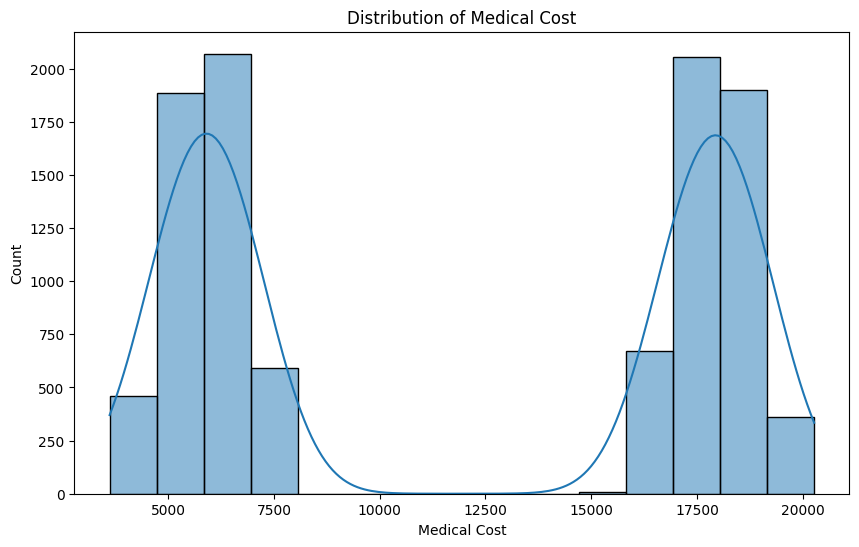

In [3]:
# Visualize the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['Medical Cost'], kde=True)
plt.title('Distribution of Medical Cost')
plt.show()


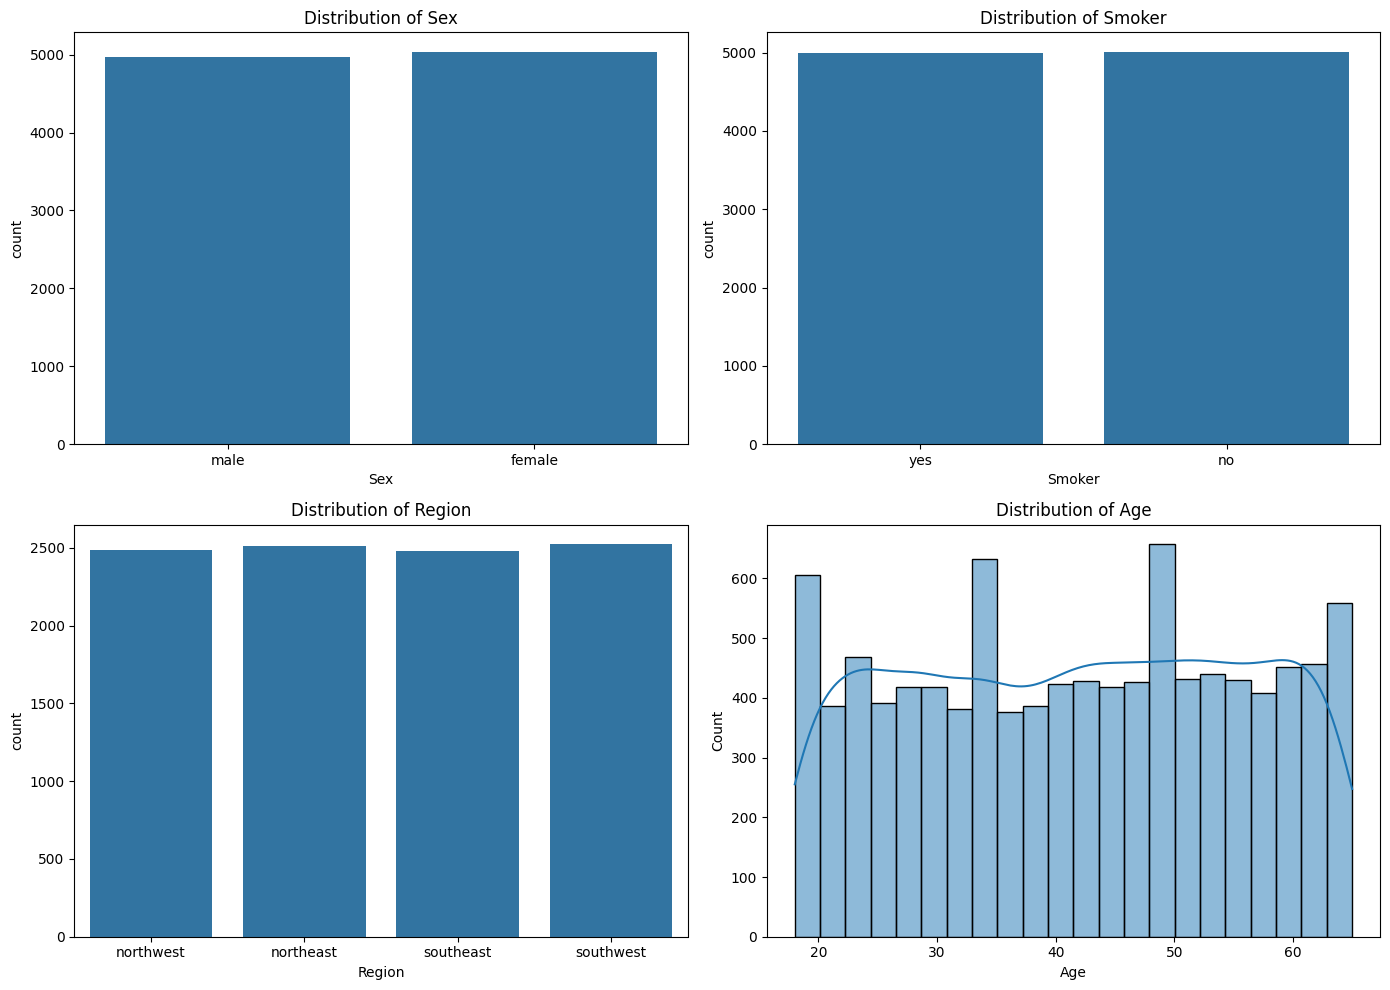

In [4]:
# Visualize the distribution of categorical variables
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.countplot(ax=axes[0, 0], x='Sex', data=df)
axes[0, 0].set_title('Distribution of Sex')

sns.countplot(ax=axes[0, 1], x='Smoker', data=df)
axes[0, 1].set_title('Distribution of Smoker')

sns.countplot(ax=axes[1, 0], x='Region', data=df)
axes[1, 0].set_title('Distribution of Region')

sns.histplot(ax=axes[1, 1], x='Age', kde=True, data=df)
axes[1, 1].set_title('Distribution of Age')

plt.tight_layout()
plt.show()


In [7]:
# Encode categorical variables
label_encoder = LabelEncoder()
df['Sex'] = label_encoder.fit_transform(df['Sex'])
df['Smoker'] = label_encoder.fit_transform(df['Smoker'])
df['Region'] = label_encoder.fit_transform(df['Region'])

# Calculate correlation matrix
corr_matrix = df.corr()


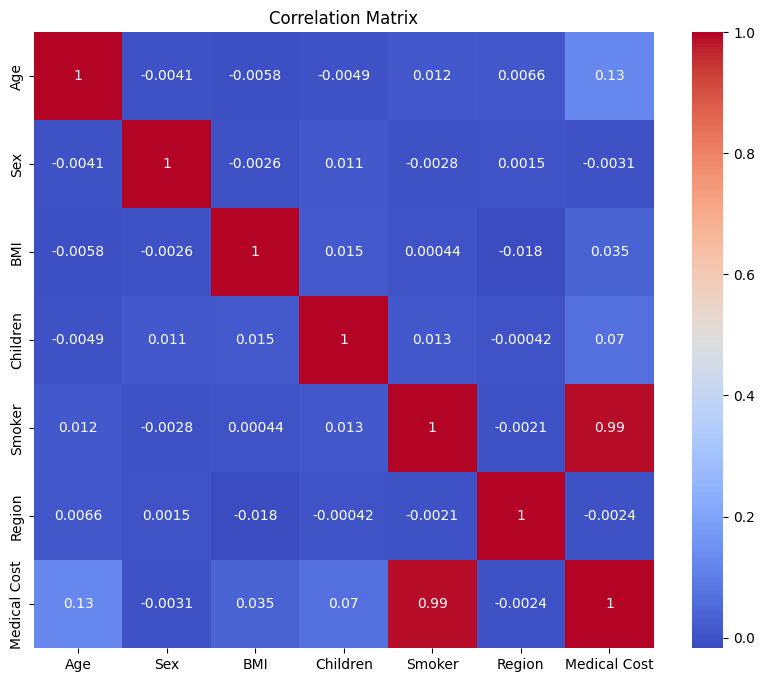

In [8]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [9]:
# Check the balance of the 'Smoker' feature
df['Smoker'].value_counts()



Smoker
0    5008
1    4992
Name: count, dtype: int64

In [10]:

# Adding interaction features
df['Age*BMI'] = df['Age'] * df['BMI']
df['Children*Smoker'] = df['Children'] * df['Smoker']

# Encode categorical features
le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])
df['Smoker'] = le.fit_transform(df['Smoker'])
df['Region'] = le.fit_transform(df['Region'])


In [11]:
# Split dataset
X = df.drop('Medical Cost', axis=1)
y = df['Medical Cost']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
# Train the model with refined hyperparameters
model = XGBRegressor(tree_method='hist', device='cuda')
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Save the model
joblib.dump(best_model, 'medical_cost_model2.pkl')


Fitting 2 folds for each of 27 candidates, totalling 54 fits


/home/mihnearad/Development/MedicalCost_Prediction/.env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [23:56:52] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.4s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.5s
[CV] END ...learning_rate=0.01, max_depth=4, n_estimators=50; total time=   0.2s
[CV] END ...learning_rate=0.01, max_depth=4, n_estimators=50; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=200; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=200; total time=   0.6s
[CV] END ...learning_rate=0.

['medical_cost_model2.pkl']

In [13]:
# Evaluate the model
predictions = best_model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Absolute Error: 255.2731832226563
Mean Squared Error: 87372.689908119
R-squared: 0.9976231463482039


In [16]:

# Define preprocessing and prediction functions
def preprocess_input(input_features):
    age, sex, bmi, children, smoker, region = input_features
    age_bmi = age * bmi
    children_smoker = children * smoker
    input_array = np.array([age, sex, bmi, children, smoker, region, age_bmi, children_smoker]).reshape(1, -1)
    return input_array

def predict_cost(input_features):
    input_array = preprocess_input(input_features)
    prediction = best_model.predict(input_array)
    return prediction[0]
# Additional Example predictions
examples = [
    [21, 1, 15, 0, 0, 1],
    [22, 1, 16, 0, 0, 1],
    [21, 0, 15, 1, 0, 1],
    [21, 1, 15, 0, 1, 1],
    [21, 1, 15, 0, 0, 2],
    [30, 1, 25, 2, 0, 0],
    [45, 0, 30, 3, 1, 2],
    [60, 1, 28, 1, 0, 3],
    [35, 0, 22, 0, 1, 0],
    [50, 1, 33, 4, 0, 1],
    [40, 0, 24, 1, 1, 2],
    [25, 1, 18, 0, 0, 0],
    [55, 0, 32, 2, 1, 1],
    [60, 1, 35, 3, 0, 2],
    [40, 1, 27, 0, 1, 3],
    [30, 0, 26, 1, 0, 1],
    [45, 1, 29, 2, 1, 2],
    [35, 0, 23, 0, 0, 3],
    [50, 1, 31, 1, 1, 0],
    [25, 0, 19, 2, 0, 2]
]

for example in examples:
    predicted_cost = predict_cost(example)
    print(f'Example: {example}, Predicted Medical Cost: ${predicted_cost:.2f}')


Example: [21, 1, 15, 0, 0, 1], Predicted Medical Cost: $4091.42
Example: [22, 1, 16, 0, 0, 1], Predicted Medical Cost: $4108.02
Example: [21, 0, 15, 1, 0, 1], Predicted Medical Cost: $4294.96
Example: [21, 1, 15, 0, 1, 1], Predicted Medical Cost: $16113.42
Example: [21, 1, 15, 0, 0, 2], Predicted Medical Cost: $4097.04
Example: [30, 1, 25, 2, 0, 0], Predicted Medical Cost: $5192.68
Example: [45, 0, 30, 3, 1, 2], Predicted Medical Cost: $18224.77
Example: [60, 1, 28, 1, 0, 3], Predicted Medical Cost: $6560.76
Example: [35, 0, 22, 0, 1, 0], Predicted Medical Cost: $16922.50
Example: [50, 1, 33, 4, 0, 1], Predicted Medical Cost: $6791.34
Example: [40, 0, 24, 1, 1, 2], Predicted Medical Cost: $17438.68
Example: [25, 1, 18, 0, 0, 0], Predicted Medical Cost: $4292.37
Example: [55, 0, 32, 2, 1, 1], Predicted Medical Cost: $18563.31
Example: [60, 1, 35, 3, 0, 2], Predicted Medical Cost: $7117.52
Example: [40, 1, 27, 0, 1, 3], Predicted Medical Cost: $17320.42
Example: [30, 0, 26, 1, 0, 1], Pre

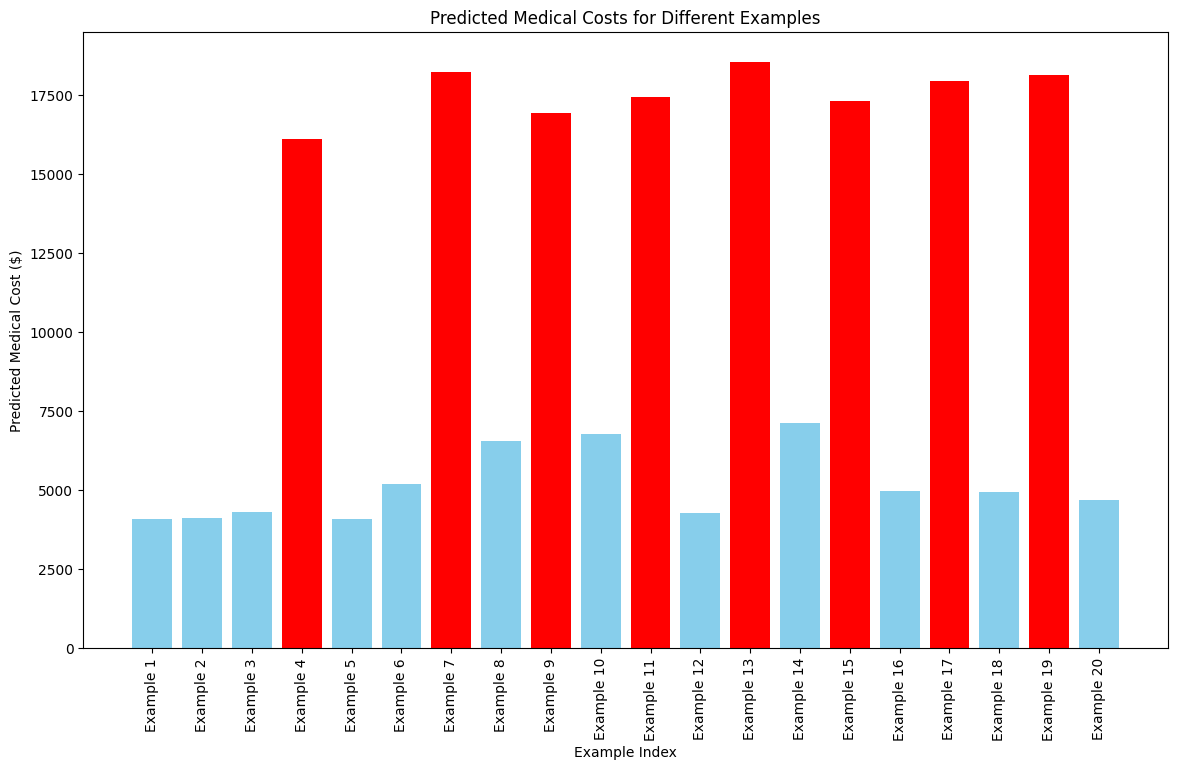

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
examples = [
    [21, 1, 15, 0, 0, 1],
    [22, 1, 16, 0, 0, 1],
    [21, 0, 15, 1, 0, 1],
    [21, 1, 15, 0, 1, 1],
    [21, 1, 15, 0, 0, 2],
    [30, 1, 25, 2, 0, 0],
    [45, 0, 30, 3, 1, 2],
    [60, 1, 28, 1, 0, 3],
    [35, 0, 22, 0, 1, 0],
    [50, 1, 33, 4, 0, 1],
    [40, 0, 24, 1, 1, 2],
    [25, 1, 18, 0, 0, 0],
    [55, 0, 32, 2, 1, 1],
    [60, 1, 35, 3, 0, 2],
    [40, 1, 27, 0, 1, 3],
    [30, 0, 26, 1, 0, 1],
    [45, 1, 29, 2, 1, 2],
    [35, 0, 23, 0, 0, 3],
    [50, 1, 31, 1, 1, 0],
    [25, 0, 19, 2, 0, 2]
]

predicted_costs = [
    4091.42, 4108.02, 4294.96, 16113.42, 4097.04, 
    5192.68, 18224.77, 6560.76, 16922.50, 6791.34, 
    17438.68, 4292.37, 18563.31, 7117.52, 17320.42, 
    4979.22, 17949.27, 4942.23, 18128.76, 4679.30
]

# Determine colors based on smoker status
colors = ['red' if example[4] == 1 else 'skyblue' for example in examples]

# Plotting
plt.figure(figsize=(14, 8))
x = np.arange(len(examples))
plt.bar(x, predicted_costs, color=colors)

# Adding labels
plt.xlabel('Example Index')
plt.ylabel('Predicted Medical Cost ($)')
plt.title('Predicted Medical Costs for Different Examples')
plt.xticks(x, [f'Example {i+1}' for i in range(len(examples))], rotation=90)

# Display the plot
plt.show()
